### 网格交易回测
静态等差网格

策略逻辑：
- 假设初始资金量为w0，网格数量为n_grid，网格距离为d_grid，maker交易手续费为tx
- 初始每个网格, limit单的资金量为 w0/n_grid
- 根据当前1分钟的close价格（c_t0），设置网格【上下摆limit单】
- 下1分钟的close(c_t1)和c_t0之间的limit单，视为成交
- 记录当前仓位w_t1，每一次价格变化，网格重新发生变化。
- 价格超出区间范围，再平仓，调整网格

策略参数：
- 区间比率 r  
    - p_a < p_0 < p_b
    - 等差 -> p_a = (1-r)p_0; p_b = (1+r)p_0
    - 等比 -> p_a = 1/(1+r)p_0; p_b = (1+r)p_0
- 网格数量 (已知上下区间和网格量，就可以得到每个区间的宽度) n_grid
- 交易手续费

策略核心：
- 选出网格的压力位和阻力位。
    - 确定适当的压力位和阻力位，使价格大部分时间能够在压力位和阻力位之间波动。如果压力位和阻力位设置范围过大，会导致难以触发交易；如果压力位和阻力位设置范围过小，则会频繁触发交易。
- 合适的交易币对
    - 围绕均值来回波动，且波动性越大越好
- 怎么去区分不同行情，不同行情下，策略的变化和影响
    - 震荡行情 -> 
    - 趋势行情 -> 
- 网格交易，就是在一定区间内，做流动性

In [1]:
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from IPython.utils import io
from functions_processing_data import get_data
from bt_grid import * 


In [2]:
# 策略参数
p0 = 10
r = 0.2
n_grid = 6

pa, pb = get_price_range(p0,r,tp="arth")
grids = get_grids(pa, pb, n_grid, tp="arth")
print("arth")
print(pa, pb, grids)

pa, pb = get_price_range(p0,r,tp="geom")
grids = get_grids(pa, pb, n_grid, tp="geom")
print("arth")
print(pa, pb, grids)

# get_quantity_on_one_grid(10, p0,r)
pa, pb = get_price_range(p0,r,tp="arth")
grids = get_grids(pa, pb, n_grid, tp="arth")
get_quantity_on_one_grid(60, grids, p0)

arth
8.0 12.0 [ 8.          8.66666667  9.33333333 10.         10.66666667 11.33333333
 12.        ]
arth
8.333333333333334 12.0 [ 8.33333333  8.85548808  9.41036029 10.         10.62658569 11.29243235
 12.        ]


1.0

In [3]:
file_name = "binance_futures_DOTUSDT_20200101_20220322.csv"
df_data = get_data(file_name)
df_data = df_data.loc[df_data.index > pd.to_datetime("2022/1/1"), :]
df_data

,open,high,low,close,volume
Time,,,,,
2022-01-01 00:01:00,26.684,26.800,26.657,26.780,22505.7
2022-01-01 00:02:00,26.784,26.809,26.739,26.789,28272.3
2022-01-01 00:03:00,26.790,26.803,26.738,26.750,13909.6
2022-01-01 00:04:00,26.750,26.755,26.723,26.724,7502.6
2022-01-01 00:05:00,26.724,26.840,26.696,26.825,24512.5
...,...,...,...,...,...
2022-03-21 23:56:00,18.768,18.786,18.768,18.785,1306.3
2022-03-21 23:57:00,18.786,18.797,18.770,18.771,5116.1
2022-03-21 23:58:00,18.772,18.772,18.755,18.760,8218.1


### Backtesting

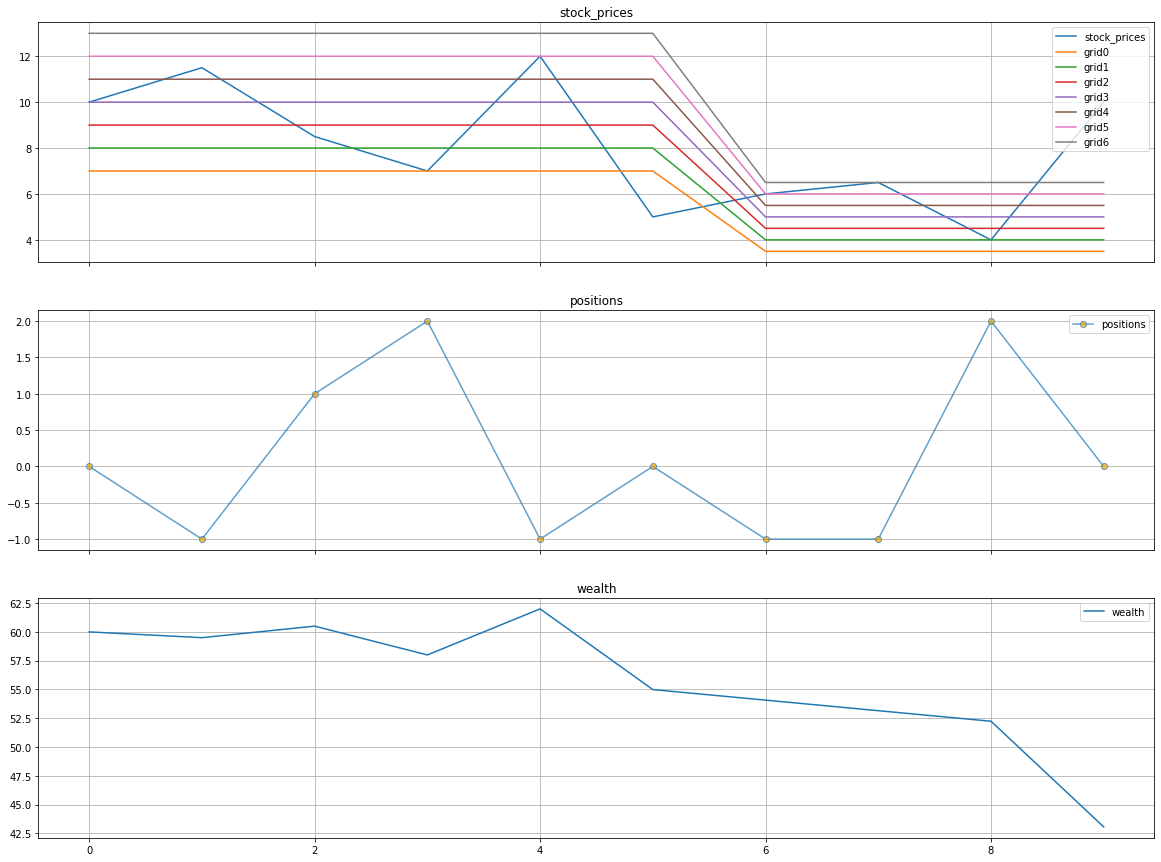

In [4]:
# 策略参数
w0 = 60
r = 0.3
n_grid = 6
tp = "arth"
data = pd.Series(np.array([10, 11.5, 8.5, 7, 12, 5, 6, 6.5, 4, 10]))
# data = pd.Series(np.array([10, 11.5, 8.5, 7, 12, 5, 6]))
# data = pd.Series(np.array([10, 9.5, 10.5, 10.5, 9.5]))

# test 
static_grid_bt = StaticGridBT(w0, r, n_grid, tp, data, is_trading_even=False, is_reverse_trading=False, tx_m=0, tx_t=0.0002)

with io.capture_output() as captured: # this will supress (e.g. capture) stdout and stderr
    static_grid_bt.run_on_bar()
static_grid_bt.plot_results()

In [5]:
# # 策略参数
# w0 = 60
# r = 0.005
# n_grid = 10
# tp = "arth"

# # test 
# static_grid_bt = StaticGridBT(w0, r, n_grid, tp, df_data.close.iloc[1:10000], is_trading_even=False, is_reverse_trading=True, tx_m=0.0002, tx_t=0.0002)

# # print("static_grid_bt.positions: ", static_grid_bt.positions)
# # static_grid_bt.pa, static_grid_bt.pb, static_grid_bt.last_grid

# with io.capture_output() as captured: # this will supress (e.g. capture) stdout and stderr
#     static_grid_bt.run_on_bar()
# static_grid_bt.plot_results()

In [6]:
# # 策略参数
# w0 = 60
# r = 0.005
# n_grid = 10
# tp = "arth"

# # test 
# static_grid_bt = StaticGridBT(w0, r, n_grid, tp, df_data.close, is_trading_even=False, is_reverse_trading=True, tx_m=0.0002, tx_t=0.0002)

# # print("static_grid_bt.positions: ", static_grid_bt.positions)
# # static_grid_bt.pa, static_grid_bt.pb, static_grid_bt.last_grid

# with io.capture_output() as captured: # this will supress (e.g. capture) stdout and stderr
#     static_grid_bt.run_on_bar()
# static_grid_bt.plot_results()

### 参数优化

In [7]:
## param optimization 

# init pool 
p = Pool(2)

# init params
lst_r = [0.1, 0.01, 0.001]
lst_n_grid = [5, 10, 20]
lst_params = []
for r in lst_r:
    for n_grid in lst_n_grid:
        lst_params.append([r,n_grid])
print(lst_params)

def f_objective(r, n_grid):
    # init backtest
    bt = StaticGridBT(w0, r, n_grid, tp, df_data.close.iloc[1:1000], is_trading_even=False, is_reverse_trading=False, tx_m=0, tx_t=0.0002)
    with io.capture_output() as captured: # this will supress (e.g. capture) stdout and stderr
        bt.run_on_bar()
        return bt.wealth

res_params = p.starmap(f_objective, lst_params)
p.close()
res_params

[[5, 5], [5, 10], [5, 20], [10, 5], [10, 10], [10, 20], [20, 5], [20, 10], [20, 20]]
